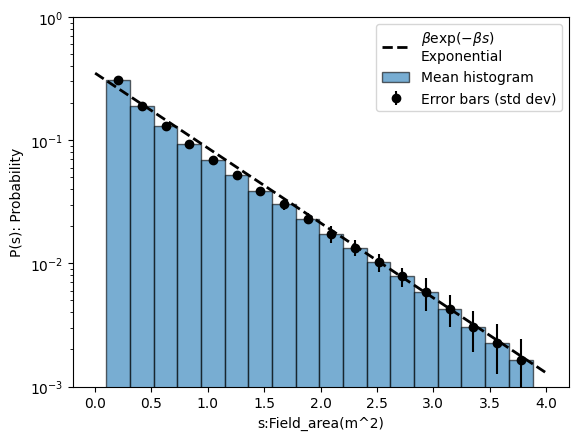

In [2]:
from scipy.ndimage import label
import numpy as np
from gp_model import GaussField, PlaceField1D, PlaceFieldModel1D, PlaceFieldComparison, PlaceField2D
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize
from scipy.stats import rayleigh
from scipy import ndimage,optimize, stats

def simulate_data(theta=1, sigma=1, N = 1000, res = 0.1, width = 5.3, height = 3.5):
  """
  simulates the place field in 5.3m * 3.5m environment with bin size of res.
  It returns array of thresholded rate maps of size N.
  
  Input:
    theta, sigma: threshold and  correlation  length
    N: size of the output array
    res: bin size (initialized to 10cm)
  """
  width = width
  height =  height
  simulated_data = []
  for _ in range(N):
    field = gaussian_filter(np.random.normal(0, 1, [int(height / res),int(width / res)]), sigma = sigma/res, mode="wrap")
    field = field / (np.sqrt(np.mean(field**2)))
    field = field - theta
    field[field < 0] = 0
    simulated_data.append(field)
  return np.array(simulated_data)

def calculate_field_sizes(data):
  """Calculates the sizes of connected fields in a 2D ratemap."""
  labeled, num_features = ndimage.label(data > 0)
  return np.asarray([np.sum(labeled == i) for i in range(1, num_features + 1)])

all_histograms = []
num_simulations = 40
bins = np.arange(0.1, 4,0.21)


for _ in range(num_simulations):
    simulated_data = simulate_data(1.2, 0.4)
    data_2D = PlaceField2D(simulated_data, 18.6)
    # calculating field sizes of every rate map in simulated data
    field_areas = np.concatenate([calculate_field_sizes(data) for data in simulated_data]) * 0.01
    counts, _ = np.histogram(field_areas, bins=bins, density=True)
    # since it is PROBABILITY, not PROBABILITY DENSITY, we need to multiply bin size
    all_histograms.append(counts * 0.21)

all_histograms = np.array(all_histograms)  # shape: (num_simulations, num_bins)
mean_counts = np.mean(all_histograms, axis=0)
std_counts = np.std(all_histograms, axis=0, ddof=1)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

plt.bar(bin_centers, mean_counts, width=bins[1] - bins[0], alpha=0.6, label='Mean histogram', edgecolor='black')
plt.errorbar(bin_centers, mean_counts, yerr=std_counts, fmt='o', color='black', label='Error bars (std dev)')
plt.yscale('log')
plt.xlabel('s:Field_area(m^2)')
plt.ylabel('P(s): Probability')
plt.ylim(1e-3, 1)

all_histograms = []

data = field_areas

def neg_log_likelihood(beta):
    if beta <= 0:
        return np.inf
    log_lik = np.sum(stats.expon.logpdf(data, scale=1/beta))
    return -log_lik


init_beta = [1.0]

# fitting the beta to the given distribution
result = optimize.minimize(neg_log_likelihood, init_beta, bounds=[(1e-12, None)])
beta_hat = result.x[0]

x = np.linspace(0, 4, 200)
beta_hat = 1.4
pdf = beta_hat * np.exp(-beta_hat * x) 
# Since we are dealing with the PROBABILITY, we should modify pdf's value to draw the well fitted pdf to the probability figure.
pdf = [ y * 0.25 for y  in pdf]  
plt.plot(x, pdf, 'k--', linewidth=2, label=r'$\beta \exp(-\beta s)$' + "\nExponential", zorder=10)
plt.legend()
plt.show()


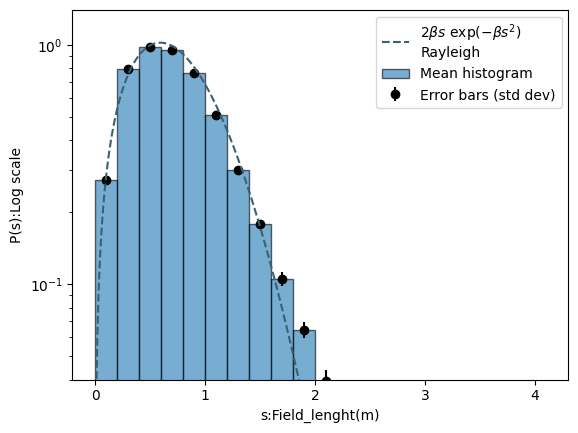

In [ ]:
all_histograms = []
num_simulations = 20
bins = np.arange(0,3,0.2)
# Making 1D slices from 2D ratemap array and compute its field length
for _ in range(num_simulations):
  simulated_data = simulate_data(1.2,0.4)
  data_2D = PlaceField2D(simulated_data, 18.6)
  x_s, y_s =  data_2D.create_1d_slices_arrays(0)
  all_segments, all_widths, all_peak_firing_rates, all_gaps = y_s.get_single_fields()
  counts, _ = np.histogram(all_widths , bins = bins, density = True)
  all_histograms.append(counts)

data = all_widths
def neg_log_likelihood(beta):
    if beta <= 0:
        return np.inf
    scale = 1 / np.sqrt(2*beta)
    return -np.sum(rayleigh.logpdf(data, loc=0, scale=scale))

beta0 = 1.0
# fitting the rayleigh distribution with the simulated distribution
res = minimize(neg_log_likelihood, [beta0], bounds=[(1e-6, None)])
beta_hat = res.x[0]
scale_hat = 1 / np.sqrt(2*beta_hat)

x = np.linspace(0, data.max(), 400)
pdf = 2 * beta_hat * x * np.exp(-beta_hat * x**2)
plt.plot(x, pdf, ls='--', color='#386273', lw=1.5, zorder=4,
         label=r"$2\beta s\ \exp(-\beta s^2)$" + "\nRayleigh")

all_histograms = np.array(all_histograms) 
mean_counts = np.mean(all_histograms, axis=0)
std_counts = np.std(all_histograms, axis=0, ddof=1)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
plt.bar(bin_centers, mean_counts, width=bins[1]-bins[0], alpha=0.6, label='Mean histogram',edgecolor='black')
plt.errorbar(bin_centers, mean_counts, yerr=std_counts, fmt='o', color='black', label='Error bars (std dev)')
plt.yscale('log')
plt.ylim(0.04, 1.4)
plt.xlabel('s:Field_lenght(m)')
plt.ylabel('P(s):Log scale')
plt.legend()
plt.show()



Text(0, 0.5, 'P(s)')

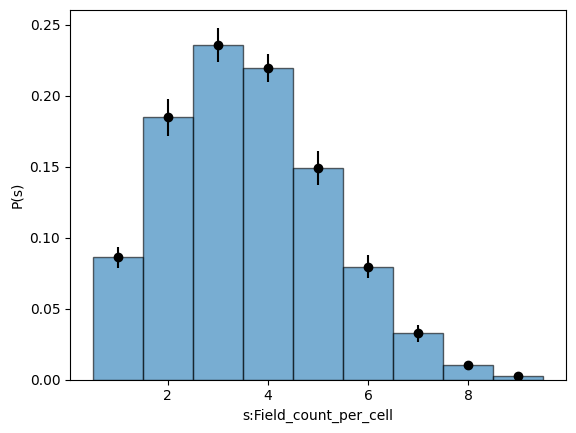

In [4]:
all_histograms = []
num_simulations = 40
bins = np.arange(0.5,10,1)
#simulating the place cell distribution 
for _ in range(num_simulations):
  simulated_data = simulate_data(1.2,0.4)
  data_2D = PlaceField2D(simulated_data, 18.6)
  field_lens = []
  for data in simulated_data:
    field_lens.append(len(calculate_field_sizes(data)))
  field_lens = np.array(field_lens)
  counts, _ = np.histogram(field_lens , bins = bins, density = True)
  all_histograms.append(counts)

all_histograms = np.array(all_histograms)
mean_counts = np.mean(all_histograms, axis=0)
std_counts = np.std(all_histograms, axis=0, ddof=1)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
plt.bar(bin_centers, mean_counts, width=bins[1]-bins[0], alpha=0.6, label='Mean histogram',edgecolor='black')
plt.errorbar(bin_centers, mean_counts, yerr=std_counts, fmt='o', color='black', label='Error bars (std dev)')
plt.xlabel('s:Field_count_per_cell')
plt.ylabel('P(s)')

In [ ]:
#Based on Original Tanni's analysis data
place_field_area_mean = 1.083
place_field_count_mean = 2.283

#Based on modified Tanni's analysis data (Changing the place cell and field detection method)
# place_field_area_mean = 0.5039
# place_field_count_mean = 3.401


def simulated_data_area_count(theta,sigma,N,res,width,height):
  simulated_data = simulate_data(theta,sigma,N,res,width,height)
  field_areas  = np.array([])
  field_counts = np.array([])
  for data in simulated_data:
    areas = calculate_field_sizes(data)
    if len(areas) > 0:
      areas = np.array(areas)
      field_areas = np.concatenate((field_areas, np.multiply(areas, 0.0025))) # 0.0025 is the area of a single bin
      field_counts = np.append(field_counts, len(areas))
  return field_areas, field_counts

def mseloss(theta,sigma):
    area, cnt = simulated_data_area_count(theta, sigma,1000,0.05,3.5,2.5)
    area = np.array(area)
    cnt = np.array(cnt)
    return (((place_field_area_mean - np.mean(area))**2) + ((place_field_count_mean - np.mean(cnt))**2)) / len(cnt)

theta_index = np.linspace(0, 2 ,21)
sigma_index = np.linspace(0, 1, 11)
min = 100
param_fit = []
t_hat = 0
s_hat = 0
for t in theta_index:
  for s in sigma_index:
    if min > mseloss(t,s):
      min  =  mseloss(t,s)
      t_hat = t
      s_hat = s
print(t_hat,s_hat)

0.8 0.5
